In [1]:
#!/usr/bin/env python3

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "/d/users/caleb/Py_Modules")
from plots import min_max, tick_array, ticks, save_show, ticks2
# from matplotlib_inline.backend_inline import set_matplotlib_formats
# set_matplotlib_formats('svg')
import numpy as np
# import pandas as pd
from astropy.table import QTable, Table, Column, vstack
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord as sc
import os
import glob
from time import sleep
import time

class sdssQuery:
    """
    NAME: sdssQuery
 
    PURPOSE: class that can be initialized using Python's urllib tools to
    send an SQL command to SDSS web services
 
    CALLING SEQUENCE: from the UNIX command line:
      
      python sdssDR9query.py ra dec

    INPUTS: ra and dec shoud be sent from the command line:

      ra - Right Ascension of position to query around in SDSS DR9
      dec - declination of position to query around in SDSS DR9

    OUTPUTS: the result of the SQL command called "query" in the
    code, below, is executed by the SDSS DR9 SQL API and
    printed at the command line.
    
    COMMENTS: This is adapted from an example provide by the SDSS 
    in an early tutorial on web services.

    Note that the SQL command passed as "query" can be changed to
    any valid SDSS string.
 
    EXAMPLES: At the Unix command line:

      python sdssDR9query.py 145.285854 34.741254
      
    should return:

      145.28585385,34.74125418,21.132605,20.059248,19.613457,19.379345,19.423323,7.7489487E-4
    """
    # ADM this is the URL of the SDSS "web services" API.
    url='http://skyserver.sdss3.org/dr9/en/tools/search/x_sql.asp'
    # ADM always return the output in .csv format
    format = 'csv'

    # ADM initialize the class with a null query.
    def __init__(self):
        self.query = ''
        self.cleanQuery = ''

    # ADM use Python's urllib module to initialize a query string.
    def executeQuery(self):
        from urllib.parse import urlencode
        from urllib.request import urlopen
        self.filterQuery()
        params = urlencode({'cmd': self.cleanQuery, 'format':self.format})
        return urlopen(self.url + '?%s' % params)

    # ADM this cleans up the syntax in the query string.
    def filterQuery(self):
        from os import linesep
        self.cleanQuery = ''
        tempQuery = self.query.lstrip()
        for line in tempQuery.split('\n'):
            self.cleanQuery += line.split('--')[0] + ' ' + linesep;

def decode_sweep_name(sweepname, nside=None, inclusive=True, fact=4):
    """Retrieve RA/Dec edges from a full directory path to a sweep file

    Parameters
    ----------
    sweepname : :class:`str`
        Full path to a sweep file, e.g., /a/b/c/sweep-350m005-360p005.fits
    nside : :class:`int`, optional, defaults to None
        (NESTED) HEALPixel nside
    inclusive : :class:`book`, optional, defaults to ``True``
        see documentation for `healpy.query_polygon()`
    fact : :class:`int`, optional defaults to 4
        see documentation for `healpy.query_polygon()`

    Returns
    -------
    :class:`list` (if nside is None)
        A 4-entry list of the edges of the region covered by the sweeps file
        in the form [RAmin, RAmax, DECmin, DECmax]
        For the above example this would be [350., 360., -5., 5.]
    :class:`list` (if nside is not None)
        A list of HEALPixels that touch the  files at the passed `nside`
        For the above example this would be [16, 17, 18, 19]
    """
    # ADM extract just the file part of the name.
    sweepname = os.path.basename(sweepname)

    # ADM the RA/Dec edges.
    ramin, ramax = float(sweepname[6:9]), float(sweepname[14:17])
    decmin, decmax = float(sweepname[10:13]), float(sweepname[18:21])

    # ADM flip the signs on the DECs, if needed.
    if sweepname[9] == 'm':
        decmin *= -1
    if sweepname[17] == 'm':
        decmax *= -1

    if nside is None:
        return [ramin, ramax, decmin, decmax]

    pixnum = hp_in_box(nside, [ramin, ramax, decmin, decmax],
                       inclusive=inclusive, fact=fact)

    return pixnum

def is_in_box(objs, radecbox):
    """Determine which of an array of objects are inside an RA, Dec box.

    Parameters
    ----------
    objs : :class:`~numpy.ndarray`
        An array of objects. Must include at least the columns "RA" and "DEC".
    radecbox : :class:`list`
        4-entry list of coordinates [ramin, ramax, decmin, decmax] forming the
        edges of a box in RA/Dec (degrees).

    Returns
    -------
    :class:`~numpy.ndarray`
        ``True`` for objects in the box, ``False`` for objects outside of the box.

    Notes
    -----
        - Tests the minimum RA/Dec with >= and the maximum with <
    """
    ramin, ramax, decmin, decmax = radecbox

    # ADM check for some common mistakes.
    if decmin < -90. or decmax > 90. or decmax <= decmin or ramax <= ramin:
        msg = "Strange input: [ramin, ramax, decmin, decmax] = {}".format(radecbox)
        log.critical(msg)
        raise ValueError(msg)

    ii = ((objs["RA"] >= ramin) & (objs["RA"] < ramax)
          & (objs["DEC"] >= decmin) & (objs["DEC"] < decmax))

    return ii

def run_q(query):
    # ADM execute the query.
    qry.query = query
    for line in qry.executeQuery():
        result = line.strip()

    # ADM NEVER remove this line! It won't speed up your code, it will
    # ADM merely overwhelm the SDSS server (a denial-of-service attack)!
    sleep(1)

    # ADM the server returns a byte-type string. Convert it to a string.
    return result.decode()

def sdss_ui_query(ra, dec):

    # ADM initialize the query.
    qry = sdssQuery()

    # ADM the query to be executed. You can substitute any query, here!
    query = ["""SELECT top 1 ra,dec,u,i FROM PhotoObj as PT
    JOIN dbo.fGetNearbyObjEq(""" + i + """,""" + j + """,0.02) as GNOE
    on PT.objID = GNOE.objID ORDER BY GNOE.distance""" for i, j in zip(ra, dec)]
    
    return qry, query

#CTE BEGIN MINE

def in_sweeps(directory, table):
	"""
    Given a directory containing sweep files and a table with 
    atleast RA and DEC columns, returns the path to any sweep file
    that contains atleast one point from the given table.
	
    Parameters
    ----------
    directory : str
    	The full path to the directory containing the sweep files.
	
	table ; astropy.table Table
		Table of data; must contain atleast RA and DEC columns

    Returns
    -------
    in_sweeps ; list of str
    	A list of paths to any sweep file that contains atleast one of the given points.
    """

    #CTE Setting the directory to search through
	sweeps_dir = directory
	sweep_list = np.array(glob.glob(sweeps_dir + "/*.fits"))

	#CTE Creating a list of boxes from the sweep names
	boxes = [decode_sweep_name(i) for i in sweep_list]

	#CTE Checking every point in every box,
	#CTE and creating a list that is len(boxes) long, where
	#CTE each term is len(table) long containing True or False
	#CTE for if a point is in the box.
	in_box = [is_in_box(table, i) for i in boxes]

	#CTE Creating an array of True/False that is len(boxes) long
	#CTE that assigns True to any box that has atleast one point from table
	true_false = np.array([np.any(i) for i in in_box])

	#CTE Finding the box indices for all Trues
	indexes = np.where(true_false == True)[0]

	#CTE Evaluating the sweep list at all Trues from above
	in_sweeps = sweep_list[indexes]

	return in_sweeps

def match_sweep(path1, sweep_dir, cen):
    
    tab = Table.read(path1)
    
    path1_coos = sc(tab['RA'], tab['DEC'])
    
    in_range = sc(cen[0]*u.deg, cen[1]*u.deg).separation(path1_coos) < cen[2]*u.deg
    
    path1_picks = path1_coos[in_range]
    
    path1_dict = {'RA':path1_picks.ra/u.deg, 'DEC':path1_picks.dec/u.deg}
    
    sweep_match = in_sweeps(sweep_dir, path1_dict)
    
    sweep_stack = np.hstack([fits.open(i, memmap=True)[1].data for i in sweep_match])
    
    return path1_coos, path1_dict, sweep_match, sweep_stack

def sweep_pick(pick_dict, sweep_stack, col_min, r_max, dist = 1*u.arcsec):
    pick_crit_1 = sc(pick_dict['RA']*u.deg, pick_dict['DEC']*u.deg).search_around_sky(
    sc(sweep_stack['RA']*u.deg, sweep_stack['DEC']*u.deg), dist)
    
    sweep_picks1 = sweep_stack[pick_crit_1[0]]
    
    w1 = np.array([f_to_m(i) for i in sweep_picks1['FLUX_W1']])
    w2 = np.array([f_to_m(i) for i in sweep_picks1['FLUX_W2']])
    col = w1 - w2
    r = np.array([f_to_m(i) for i in sweep_picks1['FLUX_R']])
    
    sweep_picks_fin = np.where((col > col_min) & (r < r_max))[0]
    
    picked = sweep_picks1[sweep_picks_fin]
    picked_ra = [str(i) for i in picked['RA']]
    picked_dec = [str(i) for i in picked['DEC']]
    
    return sweep_picks_fin, picked, picked_ra, picked_dec

def decode_res(result):
    
    split = result.split(',')
    ra = float(split[0])
    dec = float(split[1])
    u = float(split[2])
    i = float(split[3])
    
    return [ra, dec, u, i]

def decode_res2(result, tab = None):
    
    no_detection = result != 'No objects have been found'
    
    res = [decode_res(i) for i in result[no_detection]]
    ra = [i[0] for i in res]
    dec = [i[1] for i in res]
    u_mag = [i[2] for i in res]
    i_mag = [i[3] for i in res]
    
    no_detections_ins = np.where(no_detection == False)[0]
    
    ra_ins = [ra.insert(i, np.nan) for i in no_detections_ins]
    dec_ins = [dec.insert(i, np.nan) for i in no_detections_ins]
    u_ins = [u_mag.insert(i, np.nan) for i in no_detections_ins]
    i_ins = [i_mag.insert(i, np.nan) for i in no_detections_ins]
    
    return ra, dec, u_mag, i_mag

def f_to_m(flux):
    """
    Converts a given flux in nanomaggies to a magnitude.
    
    Parameters
    ----------
    flux : float
        The flux in nanomaggies.

    Returns
    -------
    m ; float or np.nan
        The converted magnitude. If flux <= 0, then a target is not detected
        and the magnitude is undefined (np.nan).
    """
    no_det = flux <= 0
    
    m = np.copy(flux)
    
    m = m.astype(float)
    
    m[no_det] = np.nan
    
    m[~no_det] = [22.5 - 2.5*np.log10(i) for i in m[~no_det]]

    return m

def m_to_f(mag):
    """
    Converts a given magnitude to a flux in nanomaggies.
    
    Parameters
    ----------
    mag : float
        The magnitude to convert.

    Returns
    -------
    f : float or -1
        The converted flux. If mag == np.nan, then a target 
        is not detected and the flux is negative (by convention).
    """
    no_det = np.isnan(mag)
    
    f = np.copy(mag)
    
    f[no_det] = -1
    
    f[~no_det] = [10**(-1*(i-22.5)/2.5) for i in f[~no_det]]

    return f

def get_fluxes(index, tab, u_mag, i_mag):
    coos = sc(tab['RA'][index]*u.deg, tab['DEC'][index]*u.deg)
    
    u_mag = u_mag[index]
    i_mag = i_mag[index]
    
    sdss_fluxes = np.array([
        m_to_f(u_mag), tab['FLUX_G'][index], 
        tab['FLUX_R'][index], m_to_f(u_mag), tab['FLUX_Z'][index]])
    
    sdss_lams = np.array([3543, 4770, 6231, 7625, 9134])
    
    wise_fluxes = np.array([
        tab['FLUX_W1'][index], tab['FLUX_W2'][index], 
        tab['FLUX_W3'][index], tab['FLUX_W4'][index]])
    
    wise_lams = np.array([33680, 46180, 120820, 221940])
    
    return coos, sdss_fluxes, sdss_lams, wise_fluxes, wise_lams

In [2]:
start = time.time()
first_path = '/d/scratch/ASTR5160/data/first/first_08jul16.fits'
sweep_path = '/d/scratch/ASTR5160/data/legacysurvey/dr9/north/sweep/9.0/'

all_first_coos, first_pick_dict, first_sweeps, sweep_stack = match_sweep(
    first_path, sweep_path, [163, 50, 3])

match_time = time.time()

print(f'Matching sweep files took {match_time-start} seconds.')

Matching sweep files took 2.1746814250946045 seconds.


In [3]:
pick_ins, sweep_picks, sweep_picks_ra, sweep_picks_dec = sweep_pick(
    first_pick_dict, sweep_stack, 0.5, 22)

pick_time = time.time()

print(f'Picking targets from sweep files took {pick_time-match_time} seconds.')

Picking targets from sweep files took 5.0814080238342285 seconds.


In [4]:
qry, query = sdss_ui_query(sweep_picks_ra, sweep_picks_dec)

quer = np.array([run_q(i) for i in query])

query_time = time.time()

print(f'SDSS Query took {query_time-pick_time} seconds.')

SDSS Query took 64.42096638679504 seconds.


In [5]:
ra, dec, u_mag, i_mag = decode_res2(quer, sweep_picks)

In [6]:
bright = np.nanargmin(u_mag)

ubrite1, ubrite1_sdss, sdss_lams, ubrite1_wise, wise_lams = get_fluxes(bright, sweep_picks, u_mag, i_mag)

Whole script took 71.84977126121521 seconds.


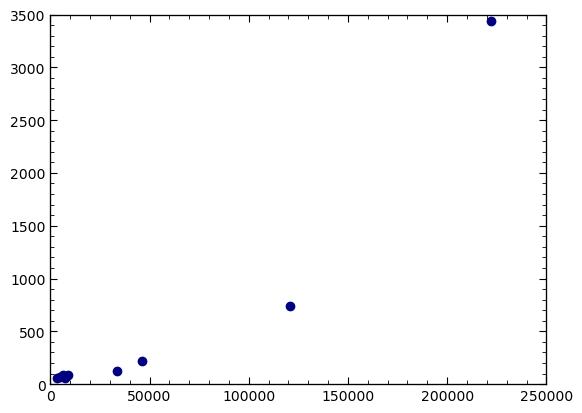

In [7]:
fig, ax = plt.subplots()

ax.scatter(sdss_lams, ubrite1_sdss, color='navy')
ax.scatter(wise_lams, ubrite1_wise, color='navy')

ticks2(ax, [0, 250000, 50000, 10000], [0, 3500, 500, 100])

end = time.time()

print(f'Whole script took {end-start} seconds.')